# Hourly Network Usage Statistics by MAC
Get detatiled and fairly accurate usage statistics for every device on your network using the version of bwmon here: https://github.com/vortex-5/ddwrt-bwmon. This is a nice little collection of scripts that interrogates the network and saves necessary information in a simple way. I wanted to be able to see changes over time, so developed this quick and dirty python program and underlying manual process to keep things running. There is still a lot that I can do to automate this, most notably using another machine as the controller - probably a RPi as it used to be before being repurposed for ADSB. 

The README.md file has more information on the hardware, but I am using a Buffalo router running DD-WRT that does not have permamanent memory. So if the router goes down there is a process to reload and restart the process. ORiginally, this was an automatic process fired off by an RPi watching on SCP, but currently it is manual. 

If the router goes down, you have to do this to restore BWMON:
```
scp -i ~/.ssh/router -r ~/Documents/repositories/Router-Tools/bwmon root@192.168.XXX.XXX:/var
scp -i ~/.ssh/router mac-names.txt root@192.168.XXX.XXX:/tmp/var/bwmon/www/mac-names.js
```

Here are some handy SCPs for the manual part of the process.

Backup the bwmon directory:
```
scp -i ~/.ssh/router -r root@192.168.XXX.XXX:/var/bwmon /Users/samuelcroker/Documents/repositories/Router-Tools/
```
Note, the bwmon directory
```
ssh -i ~/.ssh/router root@192.168.XXX.XXX
/var/bwmon/start.sh
```
The cron jobs are saved in the dd-wrt app, which appears not to be volitile. We should check that out sometime.

Grab the daily updates:
```
scp -i ~/.ssh/router root@192.168.XXX.XXX:/var/bwmon/data/*.dat ~/Documents/routerdata
```


In [1]:
import pandas as pd
import numpy as np
import datetime
import os
from os import walk
import calmap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Usage Note:
The history is maintained for all time in the second folder listed above. The router will keep all copies up until it loses power, then they are lost. For that reason, it is essential to maintain another copy. In the past, I have used a slave RPi to perform this function, but it was needed for another project so that fell by the wayside. In the current configuration I am using another computer but this is a manual process. Obviously there are lots of optimizations that can happen to fully develop this concept, but it is good enough for what it was designed to do.



In [2]:
#Get user input - router ip address
#router_ip = input()
router_ip = '192.168.11.1'

In [3]:
#update the mac list - this will only run under Macbook
#os.system("scp -i ~/.ssh/router mac-names.txt root@192.168.11.1:/tmp/var/bwmon/www/mac-names.js")
# move the dailyfiles - look for a 0 return code
os.system("scp -i ~/.ssh/router root@" + router_ip +":/var/bwmon/data/*.dat ~/Documents/routerdata")

0

In [4]:
maccsv = '/Users/samuelcroker/Documents/repositories/Router-tools/mac-names.csv'
macdf = pd.read_csv(maccsv, names = ['mac','devicename'],quotechar="'")
hourlypath = '/Users/samuelcroker/Documents/routerdata/'
hourlyfiles = []
for (dirpath, dirnames, filenames) in walk(hourlypath):
    hourlyfiles.extend(filenames)
    break
macdf['MAC'] = macdf[str.lower('mac')]

In [5]:
cutoff = 1.5
idx = 0
for f in hourlyfiles:
    date_parser = pd.to_datetime
    dtypes = {'MAC':'str','PostIN KB':'int','PostOut KB':'int','PreIn KB':'int','PreOut KB':'int','LastSeen':'str'}
    headers =  ['MAC','PostIN KB','PostOut KB','PreIn KB','PreOut KB','LastSeen']
    parse_dates =  ['LastSeen']
    if f[-3:] == 'dat' and f[0:6] == 'hourly':
        #print(f)
        df = pd.read_csv(hourlypath+f, names=headers, dtype=dtypes, parse_dates=parse_dates )
        df['idx'] = idx
        if idx == 0:
            finaldf = df.copy()                 
        else:
            finaldf = pd.concat([finaldf,df])
        idx += 1

## After successful download, consider cleaning out the remote directory

```
ssh -i ~/.ssh/router root@192.168.XXX.XXX

nvram show | grep size

cd /var/bwmon/data
rm <<files>>
```

## Augmentation of data, final prep

In [6]:
#calculate the totalGB column. This is approximate but very close...
finaldf['totalGB'] = (finaldf['PostIN KB'] + finaldf['PostOut KB'])/1e6
finaldf['dtstamp'] = finaldf['LastSeen'].dt.date
finaldf['hour'] = finaldf['LastSeen'].dt.hour
finaldf['year'] = finaldf['LastSeen'].dt.year
finaldf['day'] = finaldf['LastSeen'].dt.day
finaldf['month'] = finaldf['LastSeen'].dt.month

#join with devicenames
finaldf = finaldf.merge(macdf, left_on='MAC', right_on='MAC', how='left')

#Make sure unknown devices are not ignored in the groupby by replacing the null devicename with
# the mac address
# finaldf.devicename.fillna(finaldf['MAC'], inplace=True)

In [7]:
finaldf = finaldf[['MAC','LastSeen','dtstamp','year','month','day','hour','totalGB','devicename']]
finaldf.head()

,MAC,LastSeen,dtstamp,year,month,day,hour,totalGB,devicename
0,a8:66:7f:30:38:79,2018-04-19 02:07:00,2018-04-19,2018,4,19,2,0.000141,'Samuels MacBook'
1,5c:f5:da:b0:54:ed,2018-04-19 02:16:00,2018-04-19,2018,4,19,2,0.000188,'Joyes iPad'
2,10:ae:60:3d:3d:cd,2018-04-19 02:21:00,2018-04-19,2018,4,19,2,0.000012,'Patricks Kindle'
3,00:1f:e1:3e:09:8b,2018-04-19 02:22:00,2018-04-19,2018,4,19,2,0.000001,'Vonage'
4,28:f0:76:11:67:98,2018-04-19 02:33:00,2018-04-19,2018,4,19,2,0.000047,'iMac'


In [8]:
dyear = datetime.datetime.now().year 
dmonth =datetime.datetime.now().month - 2
if dmonth <= 0:
    dyear += -1
    dmonth = 12 + dmonth

In [9]:
# create summaries
Alltotal = finaldf.groupby(['MAC','devicename'])['totalGB'].sum()
all_final = finaldf
devicetotal = finaldf.groupby(['devicename'])['totalGB'].sum()
dailytotal = finaldf.groupby(['dtstamp'])['totalGB'].sum()
smalldaily = finaldf[finaldf.totalGB < cutoff].groupby(['dtstamp','devicename'])['totalGB'].sum()

if datetime.datetime.now().month == 1:
    lastK = datetime.date(datetime.datetime.now().year-1, 12 , 28)
else:
    lastK = datetime.date(datetime.datetime.now().year,datetime.datetime.now().month -1 , 28)
print(lastK)
recent_df = finaldf[finaldf['LastSeen']>=lastK]

2018-03-28


# Visualize the results
## Billing cycle ends on the 28th

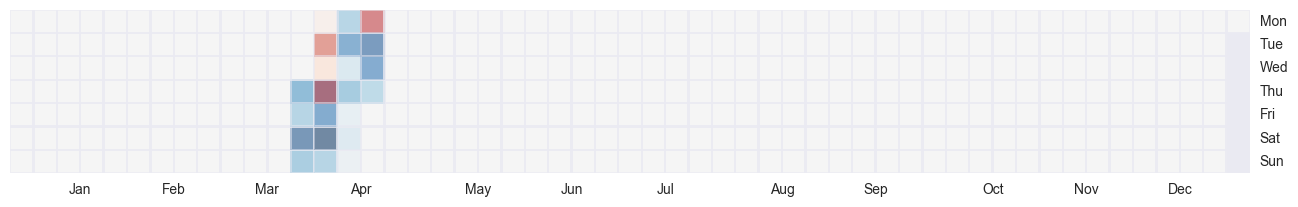

In [10]:
alldaily = pd.read_pickle('/Users/samuelcroker/Documents/routerdata/legacy.p').append(dailytotal)
alldaily.index = pd.to_datetime(alldaily.index)
plt.rcParams['figure.figsize'] = 16, 8
calmap.yearplot(data=alldaily,year=2018,cmap='RdBu_r',alpha=.55)

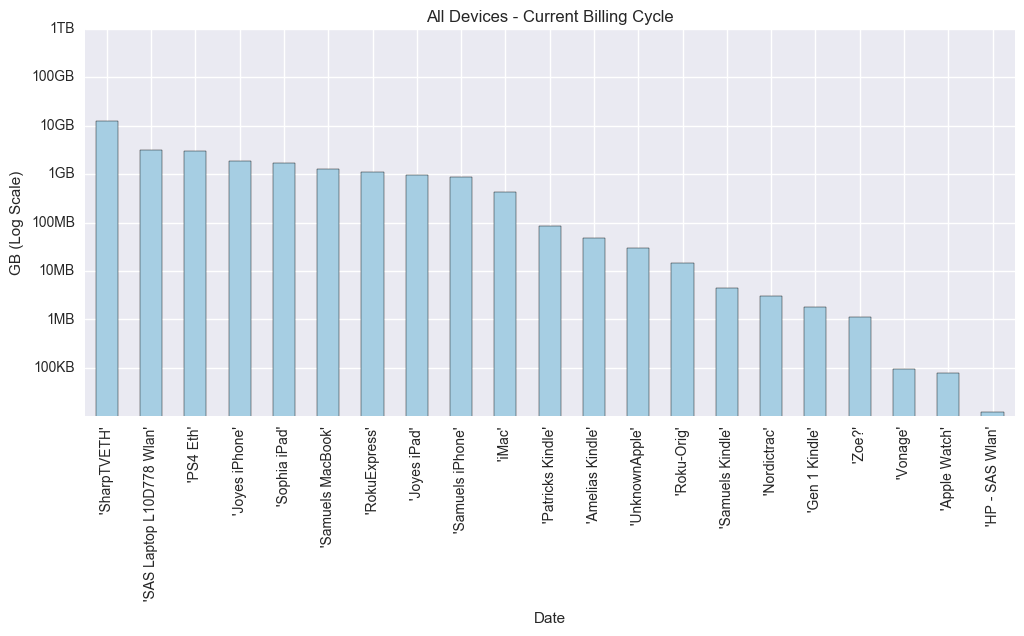

In [11]:
recent_device = recent_df.groupby(['devicename'])['totalGB'].sum()
#mx = recent_df.groupby(['devicename'])['totalGB'].sum().max().round(1)
# tt = [0.0001,0.001,0.1,1,10,100,1000,mx]
# tlab = ['100KB','1MB','100MB','1GB','10GB','100GB','1TB',mx]
tt = [0.0001,0.001,0.01,0.1,1,10,100,1000]
tlab = ['100KB','1MB','10MB','100MB','1GB','10GB','100GB','1TB']
pp0 = recent_device.sort_values(ascending=False).plot(kind='bar',
            stacked=False, colormap='Paired',figsize=(12, 5),logy=True,yticks=tt)
pp0.set_yscale = 'symlog'
pp0.set_yticklabels(tlab)
pp0.set_xlabel('Date')
pp0.set_ylabel('GB (Log Scale)')
pp0.set_title("All Devices - Current Billing Cycle")
# Make a list
# recent_device.sort_values(ascending=False)

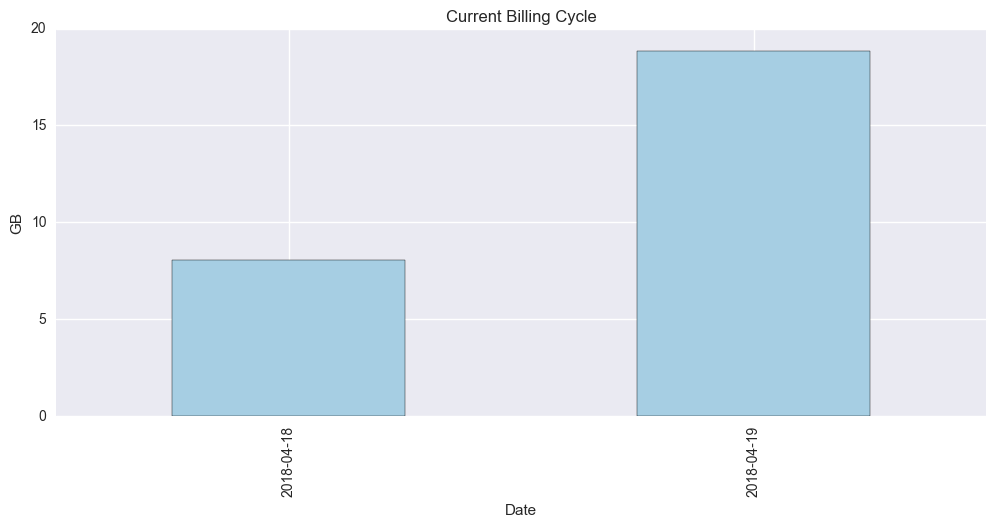

In [12]:
devicedaily = recent_df.groupby(['dtstamp'])['totalGB'].sum()
pp0 = devicedaily.plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5))
pp0.set_xlabel('Date')
pp0.set_ylabel('GB')
pp0.set_title("Current Billing Cycle")

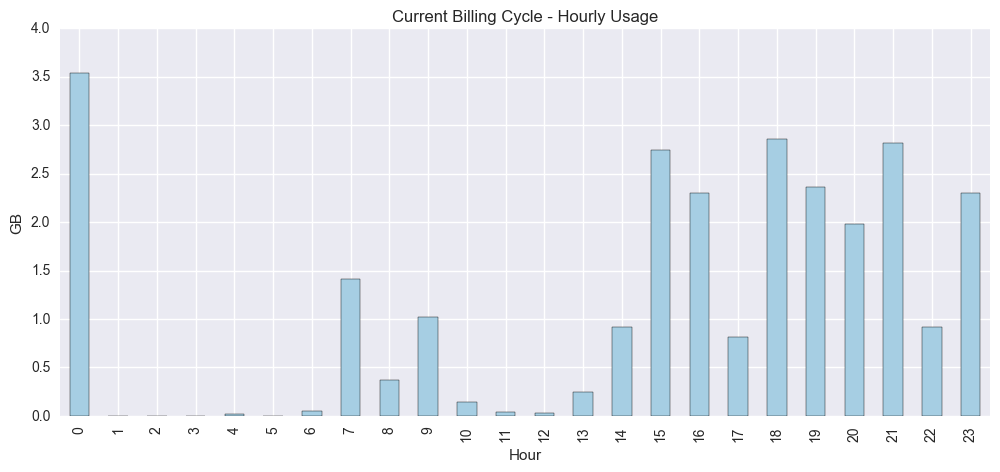

In [13]:
devicedaily = recent_df.groupby(['hour'])['totalGB'].sum().sort_index()
pp0 = devicedaily.plot(kind='bar',stacked=False, colormap='Paired',figsize=(12, 5))
pp0.set_xlabel('Hour')
pp0.set_ylabel('GB')
pp0.set_title("Current Billing Cycle - Hourly Usage")

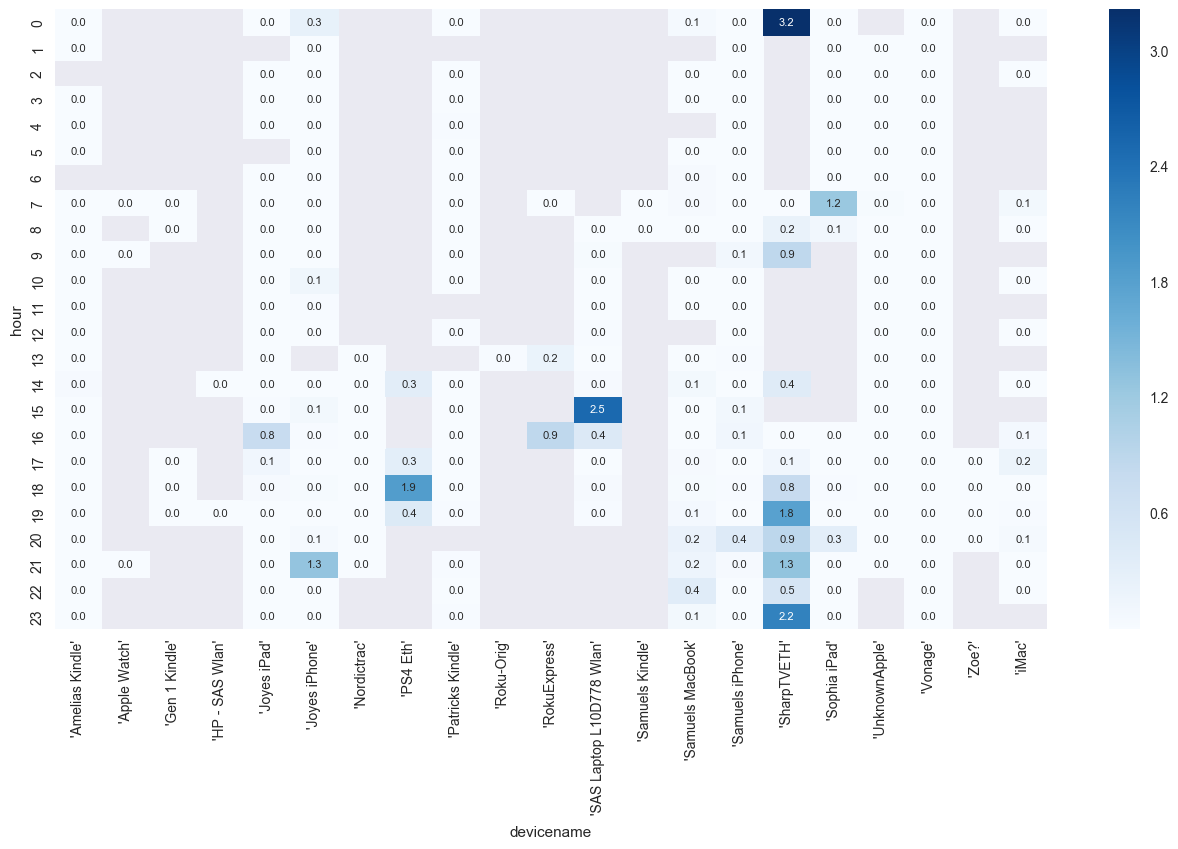

In [23]:
devicehour = pd.pivot_table(data=recent_df,index='hour',values='totalGB',columns='devicename',aggfunc='sum')#,fill_value=0)
sns.heatmap(devicehour, cmap='Blues',annot=True,fmt=".1f",annot_kws={'size':8})

In [29]:
devicehour.sum().sort_values(ascending=False)

devicename
 'SharpTVETH'                 12.392483
 'SAS Laptop L10D778 Wlan'     3.144169
 'PS4 Eth'                     2.959417
 'Joyes iPhone'                1.897446
 'Sophia iPad'                 1.693766
 'Samuels MacBook'             1.248551
 'RokuExpress'                 1.092191
 'Joyes iPad'                  0.972028
 'Samuels iPhone'              0.867509
 'iMac'                        0.424121
 'Patricks Kindle'             0.084301
 'Amelias Kindle'              0.048905
 'UnknownApple'                0.030378
 'Roku-Orig'                   0.014536
 'Samuels Kindle'              0.004442
 'Nordictrac'                  0.003011
 'Gen 1 Kindle'                0.001802
 'Zoe?'                        0.001111
 'Vonage'                      0.000094
 'Apple Watch'                 0.000078
 'HP - SAS Wlan'               0.000012
dtype: float64